## Import All Required Packages

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to /home/csuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Read Superheroes NLP Dataset

In [20]:
df = pd.read_csv('superheroes_nlp_dataset.csv')
df.head()

,name,real_name,full_name,overall_score,history_text,powers_text,intelligence_score,strength_score,speed_score,durability_score,...,has_flight,has_accelerated_healing,has_weapons_master,has_intelligence,has_reflexes,has_super_speed,has_durability,has_stamina,has_agility,has_super_strength
0,3-D Man,"Delroy Garrett, Jr.","Delroy Garrett, Jr.",6,"Delroy Garrett, Jr. grew up to become a track ...",NaN,85,30,60,60,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,514A (Gotham),Bruce Wayne,NaN,10,He was one of the many prisoners of Indian Hil...,NaN,100,20,30,50,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,A-Bomb,Richard Milhouse Jones,Richard Milhouse Jones,20,"Richard ""Rick"" Jones was orphaned at a young ...","On rare occasions, and through unusual circu...",80,100,80,100,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
3,Aa,Aa,NaN,12,Aa is one of the more passive members of the P...,NaN,80,50,55,45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aaron Cash,Aaron Cash,Aaron Cash,5,Aaron Cash is the head of security at Arkham A...,NaN,80,10,25,40,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Drop Sparse Columns

In this dataset the two text columns are history_text and powers_text. However, powers_text has a lot of null values, and sense text data cannot be easily imputed, I decided to drop this column from the data altogether and work only with the other text column, history_text. History_text had a few null values as well, but they were few enough to where dropping them from the dataframe does not drastically reduce the number of datapoints we have to draw upon, and as you can see later our accuracy was actually quite good even with only one set of text data to predict upon. This approach does only evaluate the data on one variable however, when there very well may be valuable information to be gained from looking at other data points. In this sense, my code is not in violation section 2.1 of the ACM Code of Ethics: Strive to achieve high quality in both the processes and products of professional work. However, that does not mean that given the time I could make my model more robust in its predictive power by incorporating data from the powers_text column as well. Perhaps by appending the powers_text string to the history_text string where both exist?

In [21]:
df = df.drop(df.columns.drop('creator').drop('history_text'), axis=1)
df.dropna(inplace=True)

## Deal with Creator Column (DC, Marvel, or Other)

In [22]:
df['Character Creator'] = df['creator'].apply(lambda x: x if x == "DC Comics" or x == "Marvel Comics" else "Other")

In [23]:
df.head()

,history_text,creator,Character Creator
0,"Delroy Garrett, Jr. grew up to become a track ...",Marvel Comics,Marvel Comics
1,He was one of the many prisoners of Indian Hil...,DC Comics,DC Comics
2,"Richard ""Rick"" Jones was orphaned at a young ...",Marvel Comics,Marvel Comics
3,Aa is one of the more passive members of the P...,DC Comics,DC Comics
4,Aaron Cash is the head of security at Arkham A...,DC Comics,DC Comics


## Plot the Rating Visualization Graph

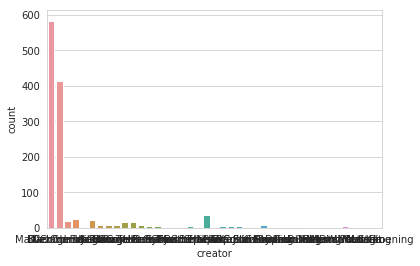

In [24]:
sns.set_style('whitegrid')
sns.countplot(x='creator',data=df)

## Plot the Character Creator count

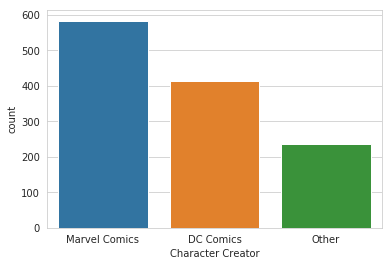

In [25]:
sns.set_style('whitegrid')
sns.countplot(x='Character Creator',data=df)

## Data Preprocessing

In [26]:
df_DC = df[df['Character Creator'] == "DC Comics"][0:8000]
df_Marvel = df[df['Character Creator'] == "Marvel Comics"]
df_Other = df[df['Character Creator'] == "Other"]

## Sample Marvel and Other from Dataset and Create Final Dataframe

In [27]:
df_Marvel_over = df_Marvel.sample(8000, replace=True)
df_Other_over = df_Other.sample(8000, replace=True)
df = pd.concat([df_DC, df_Marvel_over, df_Other_over], axis=0)
df.head()

,history_text,creator,Character Creator
1,He was one of the many prisoners of Indian Hil...,DC Comics,DC Comics
3,Aa is one of the more passive members of the P...,DC Comics,DC Comics
4,Aaron Cash is the head of security at Arkham A...,DC Comics,DC Comics
7,Originally a history professor on the planet ...,DC Comics,DC Comics
9,"""Abra Kadabra"" was a criminal time traveler fr...",DC Comics,DC Comics


## Text Preprocessing and Apply to "history_text" Column

In [28]:
def get_text_processing(text):
    stpword = stopwords.words('english')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

In [29]:
df['history'] = df['history_text'].apply(get_text_processing)
df.head()

,history_text,creator,Character Creator,history
1,He was one of the many prisoners of Indian Hil...,DC Comics,DC Comics,one many prisoners Indian Hill transferred ano...
3,Aa is one of the more passive members of the P...,DC Comics,DC Comics,Aa one passive members Pumice People race Ston...
4,Aaron Cash is the head of security at Arkham A...,DC Comics,DC Comics,Aaron Cash head security Arkham Asylum hook ha...
7,Originally a history professor on the planet ...,DC Comics,DC Comics,Originally history professor planet Ungara Abi...
9,"""Abra Kadabra"" was a criminal time traveler fr...",DC Comics,DC Comics,Abra Kadabra criminal time traveler 64th centu...


In [30]:
df = df[['history', 'Character Creator']]
df.head()

,history,Character Creator
1,one many prisoners Indian Hill transferred ano...,DC Comics
3,Aa one passive members Pumice People race Ston...,DC Comics
4,Aaron Cash head security Arkham Asylum hook ha...,DC Comics
7,Originally history professor planet Ungara Abi...,DC Comics
9,Abra Kadabra criminal time traveler 64th centu...,DC Comics


## Apply One Hot Encoding on DC, Marvel, and Other

In [31]:
one_hot = pd.get_dummies(df["Character Creator"])
df.drop(['Character Creator'],axis=1,inplace=True)
df = pd.concat([df,one_hot],axis=1)
df.head()

,history,DC Comics,Marvel Comics,Other
1,one many prisoners Indian Hill transferred ano...,1,0,0
3,Aa one passive members Pumice People race Ston...,1,0,0
4,Aaron Cash head security Arkham Asylum hook ha...,1,0,0
7,Originally history professor planet Ungara Abi...,1,0,0
9,Abra Kadabra criminal time traveler 64th centu...,1,0,0


## Training/Testing Set Split

In [32]:
X = df['history'].values
y = df.drop('history', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [33]:
vect = CountVectorizer()
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

In [34]:
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_train = X_train.toarray()
X_test = X_test.toarray()

# Create DNN Model

In [35]:
model = Sequential()

model.add(Dense(units=12673,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=4000,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=500,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=3, activation='softmax'))

opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [41]:
model.fit(x=X_train, y=y_train, batch_size=256, epochs=1, validation_data=(X_test, y_test), verbose=1, callbacks=early_stop)

45/45 [==============================] - 10s 214ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 7.3214e-04 - val_accuracy: 0.9996


In [42]:
model_score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)
print('Test accuracy:', model_score[1])

77/77 [==============================] - 1s 16ms/step - loss: 7.3214e-04 - accuracy: 0.9996
Test accuracy: 0.9995939135551453


Our model is accurate after even only one epoch, so I will not grid search the number of epochs as a hyperparameter bc it can only make the model complexity/training time go up

# Print the DNN model's confusion matrix/accuracy metrics

In [43]:
def test_accuracy_report(model):
    predicted = model.predict(X_test)
    test_predicted = np.argmax(predicted, axis=1)
    test_truth = np.argmax(y_test, axis=1)
    print(metrics.classification_report(test_truth, test_predicted, target_names=['DC', 'Marvel', 'Other'])) 
    test_res = model.evaluate(X_test, y_test, verbose=0)
    print('Loss function: %s, accuracy:' % test_res[0], test_res[1])
test_accuracy_report(model)

              precision    recall  f1-score   support

          DC       1.00      0.99      0.99       135
      Marvel       1.00      1.00      1.00      2383
       Other       1.00      1.00      1.00      2407

    accuracy                           1.00      4925
   macro avg       1.00      1.00      1.00      4925
weighted avg       1.00      1.00      1.00      4925

Loss function: 0.0007321418379433453, accuracy: 0.9995939135551453


# Train RFC and Print the Confusion Matrix/accuracy metrics

In [48]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs = -1)

param_grid = {'n_estimators' : [5, 10, 50, 100], 'max_depth' : [10, 50, 100, None]}

gs = GridSearchCV(estimator=rfc, param_grid=param_grid)

gs.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1),
             param_grid={'max_depth': [10, 50, 100, None],
                         'n_estimators': [5, 10, 50, 100]})

In [49]:
best = gs.best_estimator_
best.score(X_test, y_test)

0.9758375634517766

In [50]:
gs.best_params_

{'max_depth': None, 'n_estimators': 5}

In [51]:
rfc = RandomForestClassifier(n_jobs=-1, n_estimators=5)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.9752284263959391

In [82]:
from sklearn.metrics import multilabel_confusion_matrix
trues = y_test
preds = rfc.predict(X_test)
print(metrics.classification_report(trues, preds, target_names=['DC Comics', 'Marvel', 'Other']))

              precision    recall  f1-score   support

   DC Comics       1.00      0.10      0.18       135
      Marvel       0.97      1.00      0.98      2383
       Other       0.99      1.00      1.00      2407

   micro avg       0.98      0.98      0.98      4925
   macro avg       0.99      0.70      0.72      4925
weighted avg       0.98      0.98      0.97      4925
 samples avg       0.98      0.98      0.98      4925



/home/csuser/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
